Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Rozdział 16. Modelowanie danych sekwencyjnych za pomocą rekurencyjnych sieci neuronowych (1/2)

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-03 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [1]:
from IPython.display import Image
%matplotlib inline

# Wprowadzenie do danych sekwencyjnych

## Modelowanie danych sekwencyjnych — kolejność ma znaczenie

## Przedstawianie sekwencji



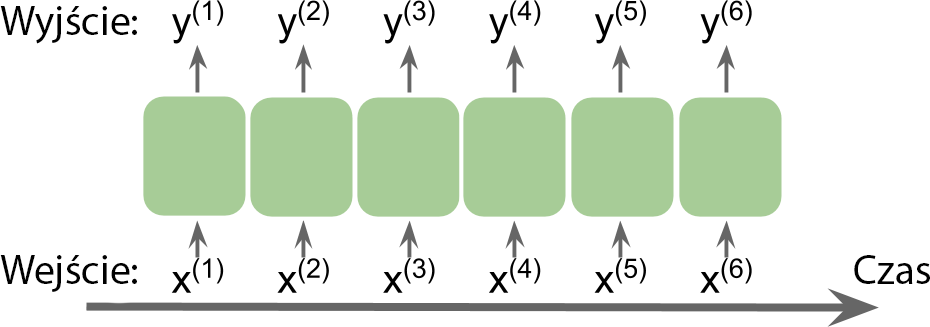

In [2]:
Image(filename='rysunki/16_01.png', width=700)

## Różne kategorie modelowania sekwencji

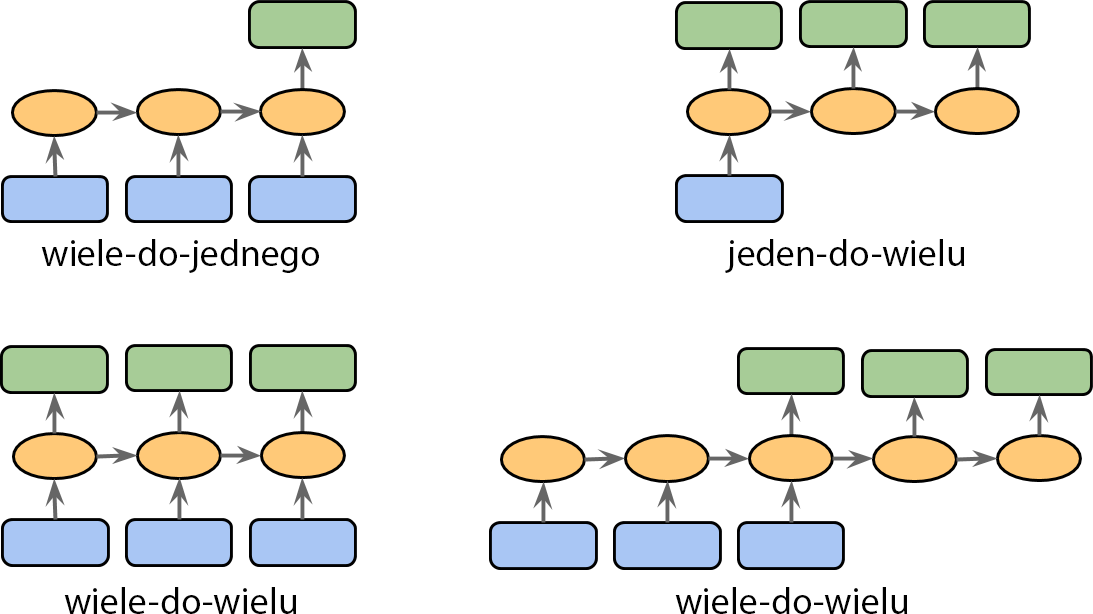

In [3]:
Image(filename='rysunki/16_02.png', width=700)

# Sieci rekurencyjne służące do modelowania sekwencji

## Mechanizm zapętlania w sieciach rekurencyjnych


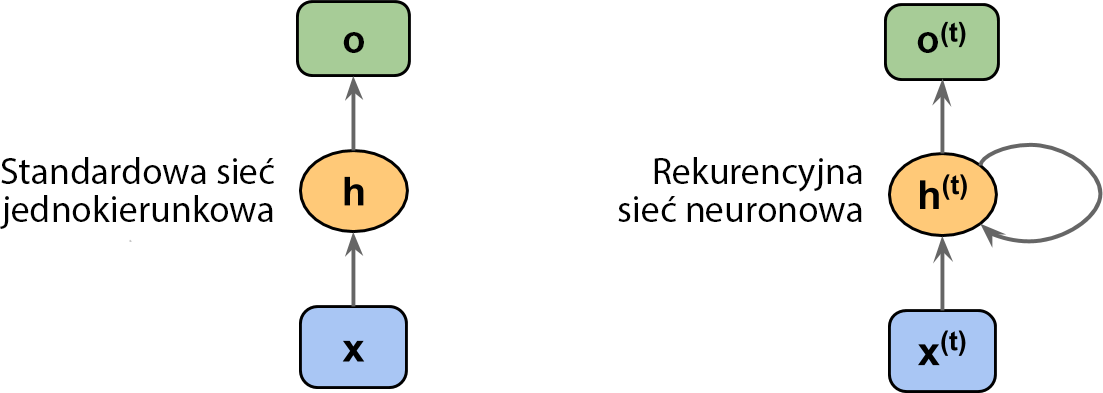

In [4]:
Image(filename='rysunki/16_03.png', width=700)

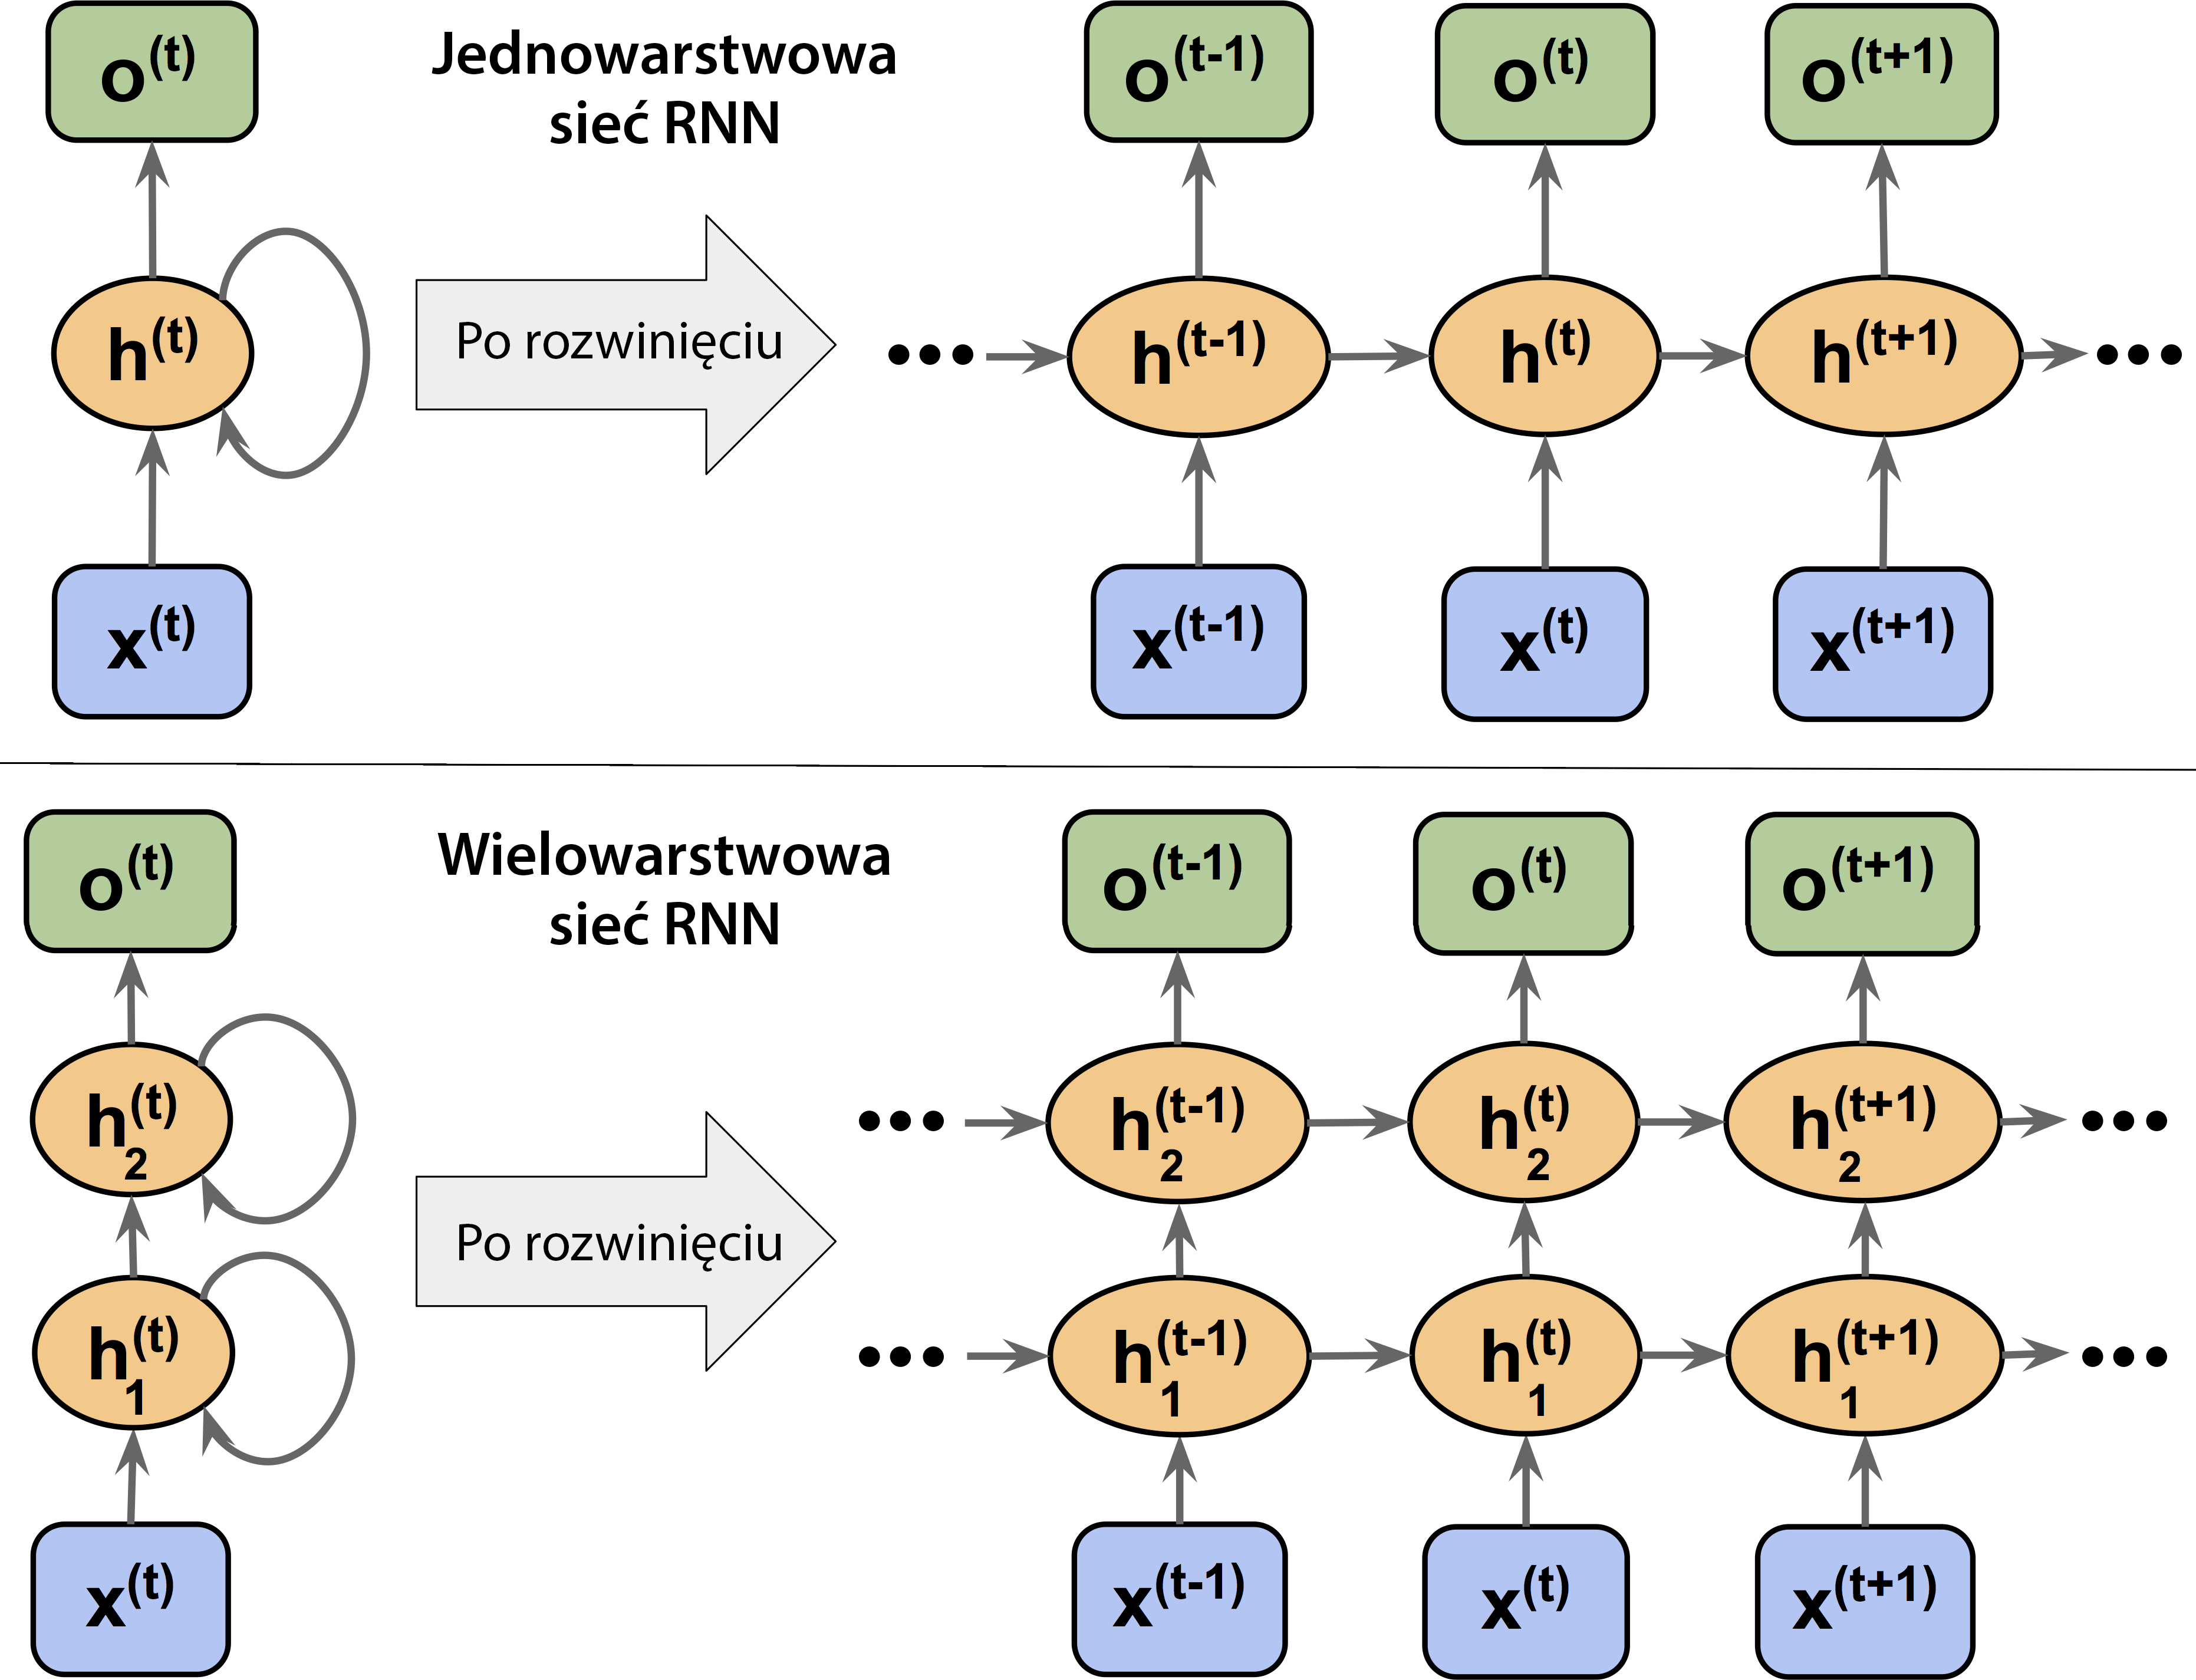

In [5]:
Image(filename='rysunki/16_04.png', width=700)

## Obliczanie aktywacji w sieciach rekurencyjnych


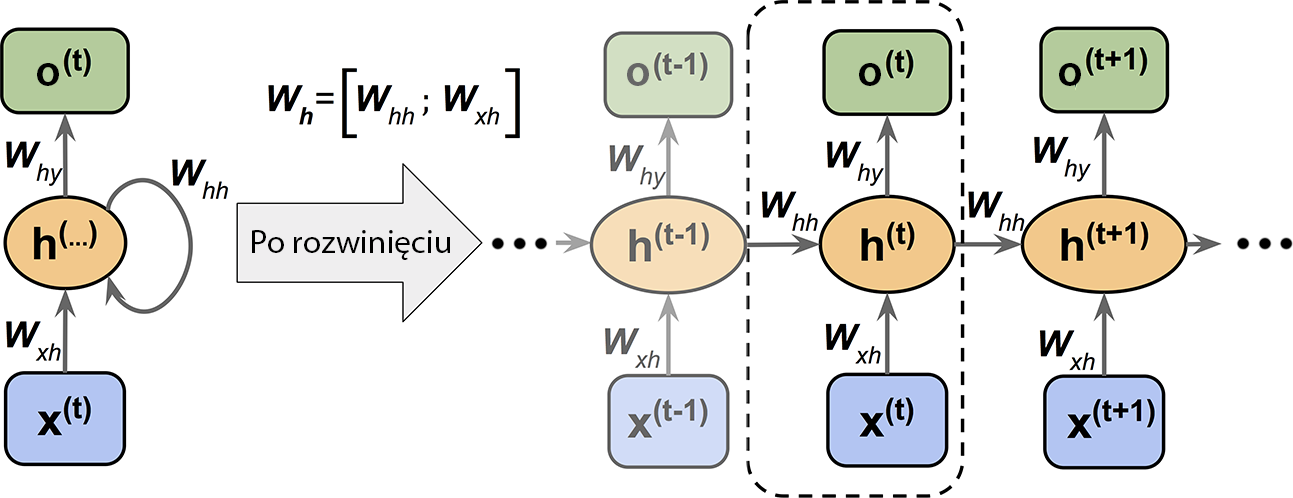

In [6]:
Image(filename='rysunki/16_05.png', width=700)

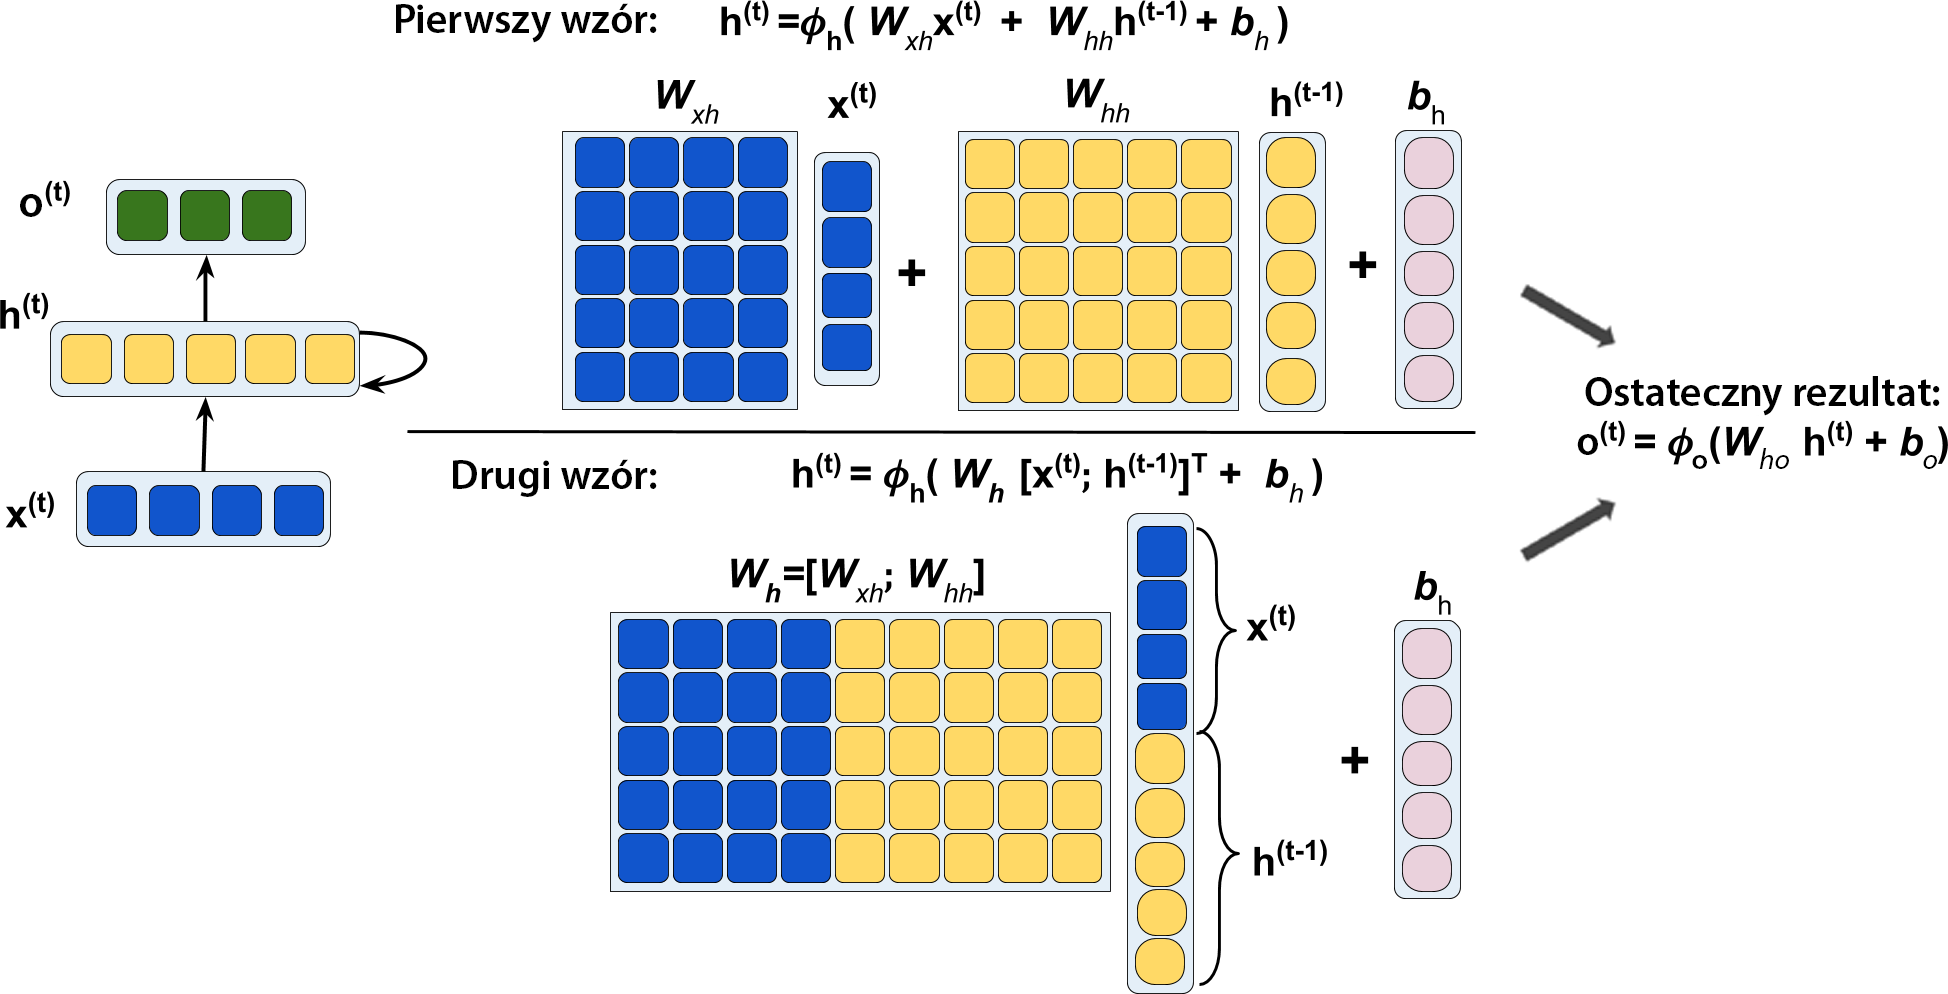

In [7]:
Image(filename='rysunki/16_06.png', width=700)

## Rekurencja w warstwie ukrytej a rekurencja w warstwie wyjściowej

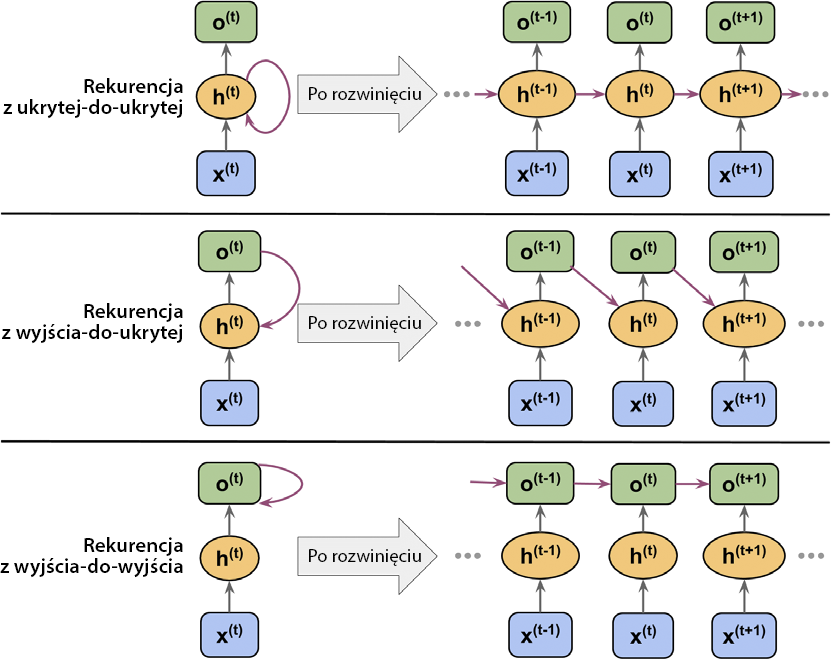

In [8]:
Image(filename='rysunki/16_07.png', width=700)

In [10]:
import tensorflow as tf
tf.random.set_seed(1)

rnn_layer = tf.keras.layers.SimpleRNN(
    units=2, use_bias=True, 
    return_sequences=True)
rnn_layer.build(input_shape=(None, None, 5))

w_xh, w_oo, b_h = rnn_layer.weights

print('Rozmiar W_xh:', w_xh.shape)
print('Rozmiar W_oo:', w_oo.shape)
print('Rozmiar b_h:', b_h.shape)

W_xh shape: (5, 2)
W_oo shape: (2, 2)
b_h shape: (2,)


In [11]:
x_seq = tf.convert_to_tensor(
    [[1.0]*5, [2.0]*5, [3.0]*5],
    dtype=tf.float32)


## wynik z klasy SimpleRNN:
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))

## ręczne obliczanie wyniku:
out_man = []
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5))
    print('Takt  {} =>'.format(t))
    print('   Wejściowa            :', xt.numpy())
    
    ht = tf.matmul(xt, w_xh) + b_h    
    print('   Ukryta           :', ht.numpy())
    
    if t>0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))
        
    ot = ht + tf.matmul(prev_o, w_oo)
    ot = tf.math.tanh(ot)
    out_man.append(ot)
    print('   Wynik (ręcznie) :', ot.numpy())
    print('   Wynik (SimpleRNN) :'.format(t), output[0][t].numpy())
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[0.41464037 0.96012145]]
   Output (manual) : [[0.39240566 0.74433106]]
   SimpleRNN output: [0.39240566 0.74433106]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[0.82928073 1.9202429 ]]
   Output (manual) : [[0.80116504 0.9912947 ]]
   SimpleRNN output: [0.80116504 0.9912947 ]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[1.243921  2.8803642]]
   Output (manual) : [[0.95468265 0.9993069 ]]
   SimpleRNN output: [0.95468265 0.9993069 ]



## Problemy z uczeniem długofalowych oddziaływań


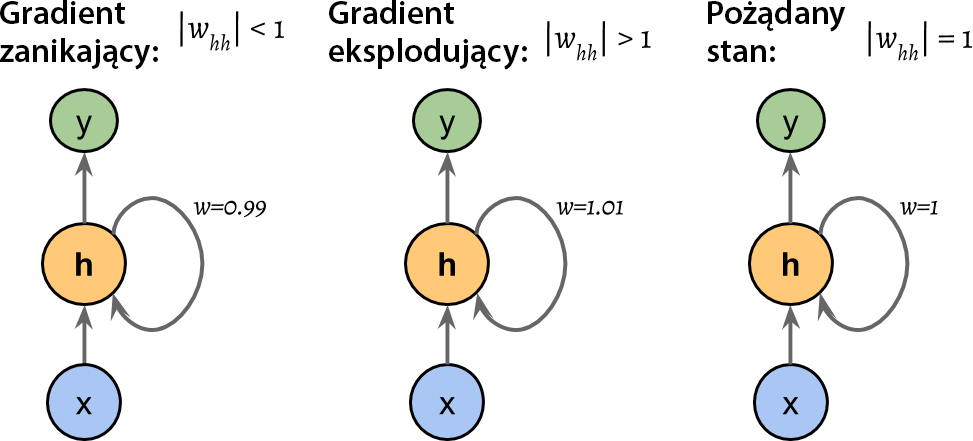

In [9]:
Image(filename='rysunki/16_08.png', width=700)


## Jednostki LSTM

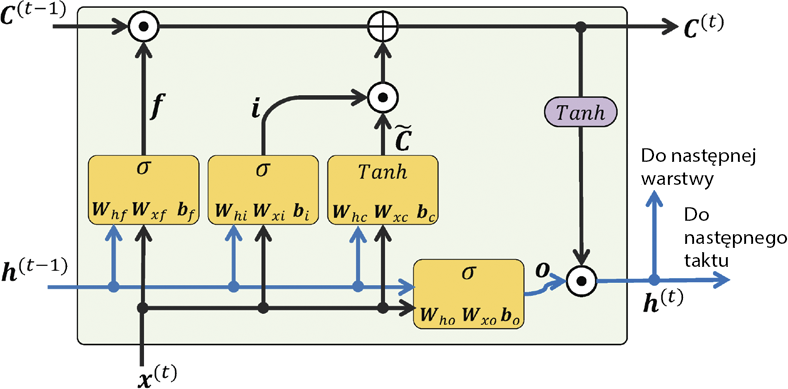

In [10]:
Image(filename='rysunki/16_09.png', width=700)

# Implementowanie wielowarstwowej sieci rekurencyjnej przy użyciu biblioteki TensorFlow do modelowania sekwencji

## Pierwszy projekt — przewidywanie sentymentów na recenzjach z zestawu danych IMDb

### Przygotowanie danych recenzji



In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [15]:
import os
import gzip
import shutil


with gzip.open('../r08/movie_data.csv.gz', 'rb') as f_in, open('movie_data.csv', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

In [16]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


In [17]:
# Etap 1.: stworzenie zestawu danych

target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

## Sprawdzenie:
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


 * **Podział na zbiory uczący/walidacyjny/testowy**

In [18]:
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(
    50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

 * **Tokenizer i koder**
   * `tfds.features.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer
   * `tfds.features.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder

 * **Kodowanie sekwencji: przechowywanie 100 ostatnich elementów w każdej sekwencji**

In [19]:
## Etap 2.: Wyszukiwanie niepowtarzalnych tokenów (wyrazów)

from collections import Counter

tokenizer = tfds.features.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Rozmiar wokabularza:', len(token_counts))

Vocab-size: 87007


In [20]:
## Etap 3.: Kodowanie tokenów do postaci liczb całkowitych

encoder = tfds.features.text.TokenTextEncoder(token_counts)

example_str = 'This is an example!'
encoder.encode(example_str)

[232, 9, 270, 1123]

In [21]:
## Etap 3A: Zdefiniowanie funkcji realizującej przekształcenie

def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

## Etap 3B: opakowanie funkcji kodującej do postaci operacji TF
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [22]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Długość sekwencji:', example[0].shape)
    
example

Sequence length: (24,)
Sequence length: (179,)
Sequence length: (262,)
Sequence length: (535,)
Sequence length: (130,)


(<tf.Tensor: id=43302, shape=(130,), dtype=int64, numpy=
 array([  579,  1296,    32,   425,    40,   763,  9267,    65,   280,
          308,     6,   481,   155,   473,     2,     3,   684,     9,
          781,   176,   959,   730,  3917,    67,  9905,    13,   277,
           24,    35,   371, 16368,     6,    14, 17231,    29,   187,
         1651,   489,   503,   480,   143,    32,   270,  5851,  2402,
           13,  3592,  3443,   425,  3313,   256,   257,  1577,   117,
            8,   698,   270,   564,    56,     8,    42,  7517,  2629,
          820,    25,    60,    79,   343,    32,   645,    14,   528,
          241,    32,  1980,     8,    56,     8,    42,  1364,   573,
         5183,    43,    12,  3870,    32,   312,   642,   251,  1401,
        17232,     8,   698,   257,   750,     2,     9,    76,   235,
            8,    42,   235,   840,   666,   258, 17233,   419,    32,
        17234,   585,   420,   840,    25,    40,    13,    14,   198,
          266,   623

 * **Porównanie metod batch() i padded_batch()**

```python

# poniższy kod spowoduje wyświetlenie błędu


BATCH_SIZE = 32
train_data = all_encoded_data.batch(BATCH_SIZE)

next(iter(train_data))

# Powyższy kod spowoduje błąd
# Nie możemy użyć metody .batch() na tym zestawie danych
```

In [23]:
## Pobiera mały podzbiór

ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Rozmiar przykładu:', example[0].shape)

## Dzieli zestaw danych na grupy
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], []))

for batch in ds_batched:
    print('Rozmiar grupy:', batch[0].shape)

Individual Shape: (119,)
Individual Shape: (688,)
Individual Shape: (308,)
Individual Shape: (204,)
Individual Shape: (326,)
Individual Shape: (240,)
Individual Shape: (127,)
Individual Shape: (453,)
Batch Shape: (4, 688)
Batch Shape: (4, 453)


In [24]:
## dzieli zbiory danych na grupy
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

### Warstwy wektorów właściwościowych w kodowaniu zdań


 * `input_dim`: liczba słów, tj. maksymalna wartość indeksu + 1.
 * `output_dim`: 
 * `input_length`: długość sekwencji (uzupełnionej zerami)
    * na przykład, `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`   
    => input_lenght ma wartość 10
 
 

 * Podczas wywoływania warstwy na wejściu przyjmowane są wartości całkowite,   
 warstwa wektorów właściwościowych przekształca każdą wartość całkowitą w wektor wartości zmiennoprzecinkowych o rozmiarze `[output_dim]`
   * Jeżeli wymiary danych wejściowych są równe `[BATCH_SIZE]`, wymiary danych wyjściowych przyjmą postać `[BATCH_SIZE, output_dim]`
   * Jeżeli wymiary danych wejściowych są równe `[BATCH_SIZE, 10]`, wymiary danych wyjściowych przyjmą postać `[BATCH_SIZE, 10, output_dim]`

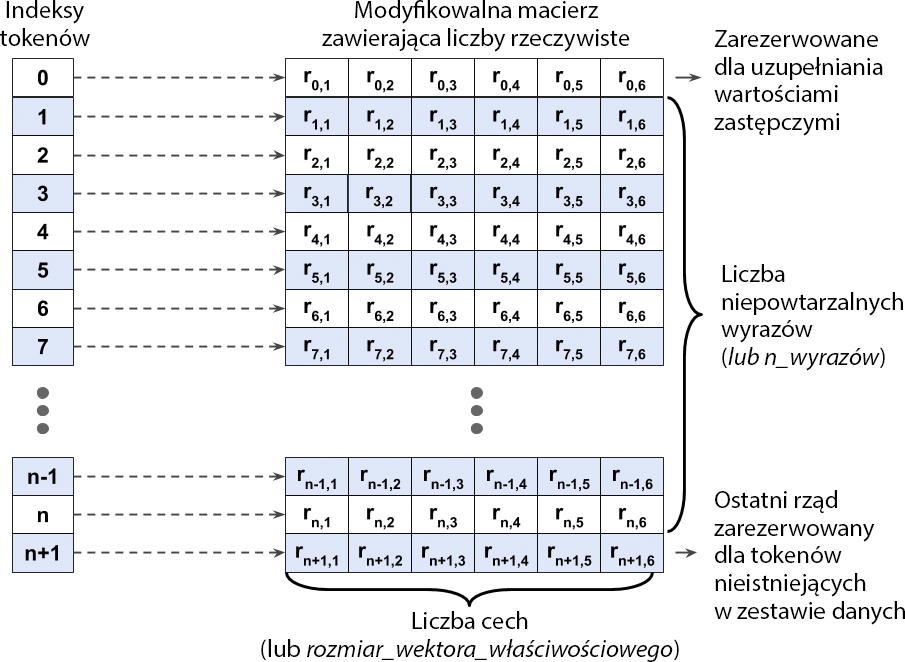

In [11]:
Image(filename='rysunki/16_10.png', width=700)

In [26]:
from tensorflow.keras.layers import Embedding


model = tf.keras.Sequential()

model.add(Embedding(input_dim=100,
                    output_dim=6,
                    input_length=20,
                    name='warstwa-osadzania'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, 20, 6)             600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


### Budowanie modelu sieci rekurencyjnej

* **Warstwy sieci RNN w interfejsie Keras:**
  * `tf.keras.layers.SimpleRNN(units, return_sequences=False)`
  * `tf.keras.layers.LSTM(..)`
  * `tf.keras.layers.GRU(..)`
  * `tf.keras.layers.Bidirectional()`
 
* **Określanie `return_sequences=?`**
  * W wielowarstwowej sieci rekurencyjnej, we wszystkich warstwach oprócz ostatniej powinien być zdefiniowany atrybut `return_sequenes=True`
  * W ostatniej warstwie rekurencyjnej wartość tego atrybutu jest zależna od rodzaju problemu: 
     * wiele-do-wielu: -> `return_sequences=True`
     * wiele-do-jednego : -> `return_sequenes=False`
     * ..
    

In [27]:
## Przykład tworzenia modelu RNN za pomocą warstwy SimpleRNN

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [28]:
## przykład tworzenia modelu RNN za pomocą warstwy LSTM


from tensorflow.keras.layers import LSTM


model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [29]:
## przykład tworzenia modelu RNN za pomocą warstwy GRU

from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(10000, 32))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 332,705
Trainable params: 332,705
Non-trainable params: 0
_________________________________________________________________


### Uczenie modelu sieci rekurencyjnej przeznaczonego do analizy sentymentów

In [30]:
embedding_dim = 20
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

## tworzy model
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='warstwa-osadzania'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='warstwa-lstm'),
        name='dwukierunkowa-lstm'), 

    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

## kompilacja i uczenie:
bi_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = bi_lstm_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

## ocena na danych testowych
test_results= bi_lstm_model.evaluate(test_data)
print('Dokładność testowa: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               43520     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 383s 613ms/step - loss: 0.5173 - accuracy: 0.7376 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 369s 590ms/step - loss: 0.2747 - a

In [31]:
if not os.path.exists('modele'):
    os.mkdir('modele')


bi_lstm_model.save('modele/Dwukier-LSTM-pelna-dlug-sekw.h5')

 * **Sprawdzenie działania modelu SimpleRNN na krótkich sekwencjach**

In [32]:
def preprocess_datasets(
    ds_raw_train, 
    ds_raw_valid, 
    ds_raw_test,
    max_seq_length=None,
    batch_size=32):
    
    ## (Etap 1. został już zrealizowany)
    ## Etap 2.: Wyszukiwanie niepowtarzalnych tokenów
    tokenizer = tfds.features.text.Tokenizer()
    token_counts = Counter()

    for example in ds_raw_train:
        tokens = tokenizer.tokenize(example[0].numpy()[0])
        if max_seq_length is not None:
            tokens = tokens[-max_seq_length:]
        token_counts.update(tokens)

    print('Rozmiar wokabularza:', len(token_counts))


    ## Etap 3.: Kodowanie tekstów
    encoder = tfds.features.text.TokenTextEncoder(token_counts)
    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seq_length is not None:
            encoded_text = encoded_text[-max_seq_length:]
        return encoded_text, label

    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label], 
                              Tout=(tf.int64, tf.int64))

    ds_train = ds_raw_train.map(encode_map_fn)
    ds_valid = ds_raw_valid.map(encode_map_fn)
    ds_test = ds_raw_test.map(encode_map_fn)

    ## Etap 4.: Tworzenie minigrup
    train_data = ds_train.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    valid_data = ds_valid.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    test_data = ds_test.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    return (train_data, valid_data, 
            test_data, len(token_counts))

In [33]:
def build_rnn_model(embedding_dim, vocab_size,
                    recurrent_type='SimpleRNN',
                    n_recurrent_units=64,
                    n_recurrent_layers=1,
                    bidirectional=True):

    tf.random.set_seed(1)

    # tworzy model
    model = tf.keras.Sequential()
    
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='warstwa-osadzania')
    )
    
    for i in range(n_recurrent_layers):
        return_sequences = (i < n_recurrent_layers-1)
            
        if recurrent_type == 'SimpleRNN':
            recurrent_layer = SimpleRNN(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='warstwa-simplernn-{}'.format(i))
        elif recurrent_type == 'LSTM':
            recurrent_layer = LSTM(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='warstwa-lstm-{}'.format(i))
        elif recurrent_type == 'GRU':
            recurrent_layer = GRU(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='warstwa-gru-{}'.format(i))
        
        if bidirectional:
            recurrent_layer = Bidirectional(
                recurrent_layer, name='dwukier-'+recurrent_layer.name)
            
        model.add(recurrent_layer)

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model


In [34]:
from tensorflow.keras.layers import Bidirectional


batch_size = 32
embedding_dim = 20
max_seq_length = 100

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=True)

rnn_model.summary()

Vocab-size: 58063
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1161300   
_________________________________________________________________
bidir-simprnn-layer-0 (Bidir (None, 128)               10880     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,180,501
Trainable params: 1,180,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])


history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 68s 109ms/step - loss: 0.7055 - accuracy: 0.5026 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.7037 - accuracy: 0.5113 - val_loss: 0.6953 - val_accuracy: 0.5072
Epoch 3/10
625/625 [==============================] - 66s 106ms/step - loss: 0.6954 - accuracy: 0.5213 - val_loss: 0.6884 - val_accuracy: 0.5452
Epoch 4/10
625/625 [==============================] - 67s 106ms/step - loss: 0.6317 - accuracy: 0.6259 - val_loss: 0.6152 - val_accuracy: 0.6522
Epoch 5/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4913 - accuracy: 0.7629 - val_loss: 0.7798 - val_accuracy: 0.6278
Epoch 6/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4252 - accuracy: 0.8094 - val_loss: 0.6105 - val_accuracy: 0.7432
Epoch 7/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4100 - accuracy: 0.8122 - val_loss: 0.6718 

In [36]:
results = rnn_model.evaluate(test_data)

782/782 [==============================] - 39s 50ms/step - loss: 0.7098 - accuracy: 0.7478


In [37]:
print('Dokładność testowa: {:.2f}%'.format(results[1]*100))

Test Acc.: 74.78%


## Dodatkowe ćwiczenie: 

### Jednokierunkowa sieć SimpleRNN dla pełnych sekwencji

In [38]:
batch_size = 32
embedding_dim = 20
max_seq_length = None

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=False)

rnn_model.summary()

Vocab-size: 87007
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
simprnn-layer-0 (SimpleRNN)  (None, 64)                5440      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,749,845
Trainable params: 1,749,845
Non-trainable params: 0
_________________________________________________________________


In [39]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5006 - val_loss: 0.6998 - val_accuracy: 0.5010
Epoch 3/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6968 - accuracy: 0.5034 - val_loss: 0.6960 - val_accuracy: 0.5004
Epoch 4/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6958 - accuracy: 0.5038 - val_loss: 0.6953 - val_accuracy: 0.5002
Epoch 5/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6952 - accuracy: 0.5045 - val_loss: 0.6947 - val_accuracy: 0.4952
Epoch 6/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6945 - accuracy: 0.5080 - val_loss: 0.6945 - val_accuracy: 0.4956
Epoch 7/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6940 - accuracy: 0.5109 - val_loss: 

# Dodatek


### A) Alternatywny sposób uzyskania zestawu danych: za pomocą tensorflow_datasets

In [40]:
imdb_bldr = tfds.builder('imdb_reviews')
print(imdb_bldr.info)

imdb_bldr.download_and_prepare()

datasets = imdb_bldr.as_dataset(shuffle_files=False)

datasets.keys()


tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word V

dict_keys(['test', 'train', 'unsupervised'])

In [41]:
imdb_train = datasets['train']
imdb_train = datasets['test']

### B) Tokenizer i koder

 * `tfds.features.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer
 * `tfds.features.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder



In [42]:
vocab_set = {'a', 'b', 'c', 'd'}
encoder = tfds.features.text.TokenTextEncoder(vocab_set)
print(encoder)

print(encoder.encode(b'a b c d, , : .'))

print(encoder.encode(b'a b c d e f g h i z'))

<TokenTextEncoder vocab_size=6>
[2, 1, 4, 3]
[2, 1, 4, 3, 5, 5, 5, 5, 5, 5]


### C) Wstępne przetwarzanie tekstu w interfejsie Keras 

In [43]:
TOP_K = 200
MAX_LEN = 10

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(['this is an example', 'je suis en forme '])
sequences = tokenizer.texts_to_sequences(['this is an example', 'je suis en forme '])
print(sequences)

tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_LEN)

[[1, 2, 3, 4], [5, 6, 7, 8]]


array([[0, 0, 0, 0, 0, 0, 1, 2, 3, 4],
       [0, 0, 0, 0, 0, 0, 5, 6, 7, 8]], dtype=int32)

In [44]:
TOP_K = 20000
MAX_LEN = 500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(
    [example['text'].numpy().decode('utf-8') 
     for example in imdb_train])

x_train = tokenizer.texts_to_sequences(
    [example['text'].numpy().decode('utf-8')
     for example in imdb_train])

print(len(x_train))


x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=MAX_LEN)

print(x_train_padded.shape)

25000
(25000, 500)


### D) Osadzanie



In [45]:
from tensorflow.keras.layers import Embedding


tf.random.set_seed(1)
embed = Embedding(input_dim=100, output_dim=4)

inp_arr = np.array([1, 98, 5, 6, 67, 45])
tf.print(embed(inp_arr))
tf.print(embed(inp_arr).shape)

tf.print(embed(np.array([1])))

[[-0.0208060984 0.0142502077 0.0475785471 -0.00649005175]
 [-0.00420691818 -0.0375086069 -0.00477621704 0.00311584398]
 [0.028728161 -0.0440448038 -0.0428906195 -0.019158531]
 [-0.0248817336 0.0408470519 -0.00285203382 -0.0257614851]
 [0.0443614833 0.00331580639 0.043055404 -0.011118304]
 [-0.0281324144 0.00720113516 0.0192188732 -0.0186921246]]
TensorShape([6, 4])
[[-0.0208060984 0.0142502077 0.0475785471 -0.00649005175]]


<br>
<br>

---



Czytelnicy mogą zignorować poniższą komórkę.


In [46]:
! python ../.convert_notebook_to_script.py --input r16_cz1.ipynb --output r16_cz1.py

[NbConvertApp] Converting notebook ch16_part1.ipynb to script
[NbConvertApp] Writing 17277 bytes to ch16_part1.py
